# APA Laboratori 3 - Clustering 

In [1]:
# uncomment for installing missing packages
# install.packages("cclust")
# install.packages('ggplot2')
# install.packages('RColorBrewer')
# install.packages("Rmixmod")

In [2]:
options(repr.plot.width=6, repr.plot.height=6)

In [3]:
set.seed(222)

## Example 1. Clustering easy artificial 2D data with k-means


First we create a simple data set:

the cclust library contains some clustering functions, including k-means

In [4]:
library (cclust)

In [5]:
N1 <- 30
N2 <- 40
N3 <- 50

create cluster 1

In [6]:
x1 <- rnorm (N1,1,0.5)
y1 <- rnorm (N1,1,0.5)

 create cluster 2

In [7]:
x2 <- rnorm (N2,2,0.5)
y2 <- rnorm (N2,6,0.7)

create cluster 3

In [8]:
x3 <- rnorm (N3,7,1)
y3 <- rnorm (N3,7,1)

create the data

In [9]:
x <- rbind (cbind(x1,y1), cbind(x2,y2), cbind(x3,y3))
c <- c(rep("1", N1), rep("2", N2), rep("3", N3))
D <- data.frame (x,color=c)

this is your data

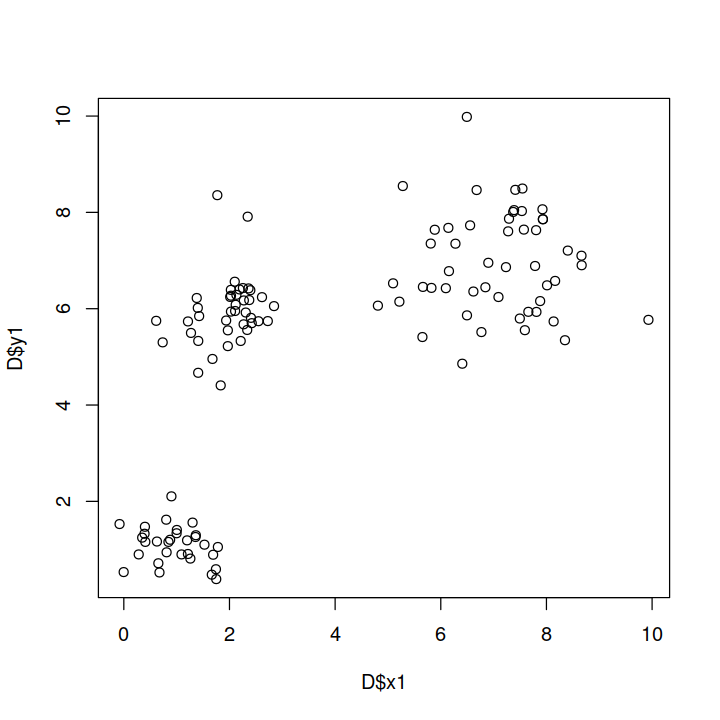

In [10]:
options(repr.plot.width=6, repr.plot.height=6)
plot(D$x1,D$y1)

and these are the true clusters

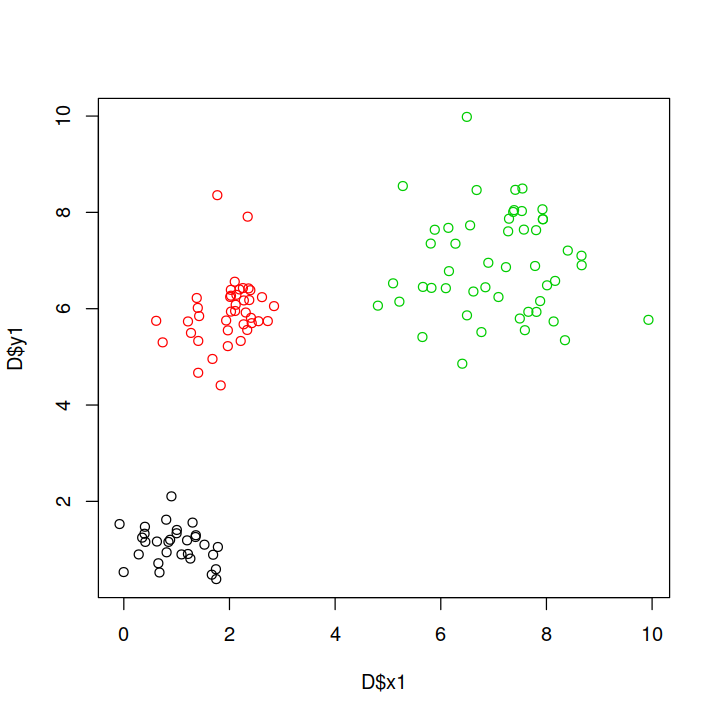

In [11]:
plot(D$x1,D$y1,col=as.vector(D$color))

 so we have 3 very clean clusters ...

Let's execute k-means

In [12]:
K <- 3 # yeah, this is tricky, why 3?

 execute k-means with a maximum of 100 iterations

In [13]:
kmeans.3 <- cclust (x,K,iter.max=100,method="kmeans",dist="euclidean")

plot initial and final prototypes (cluster centers) and  draw arrows to see the process

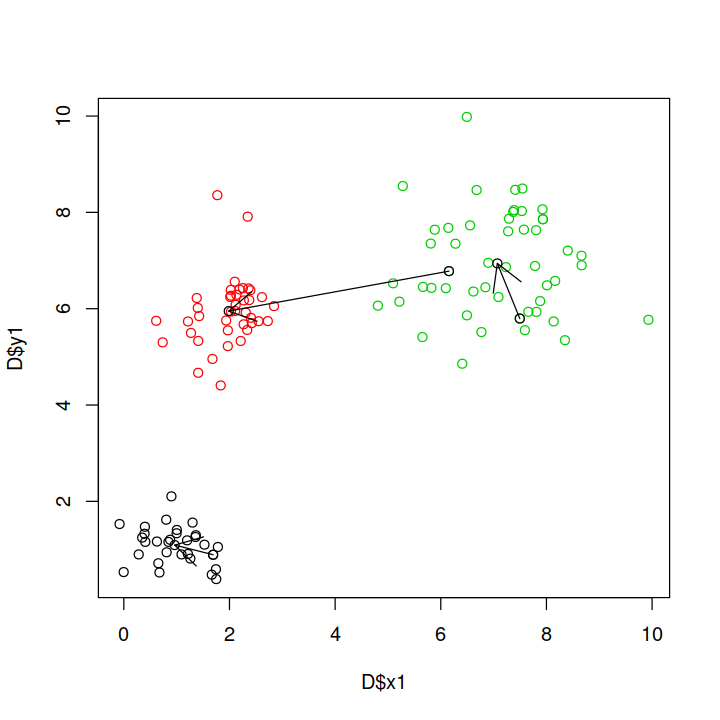

In [14]:
plot(D$x1,D$y1,col=as.vector(D$color))
points(kmeans.3$initcenters)
points(kmeans.3$centers)

arrows (kmeans.3$initcenters[,1], kmeans.3$initcenters[,2],
        kmeans.3$centers[,1], kmeans.3$centers[,2])

plot and paint the clusters (according to the computed assignments) and plot the cluster centers

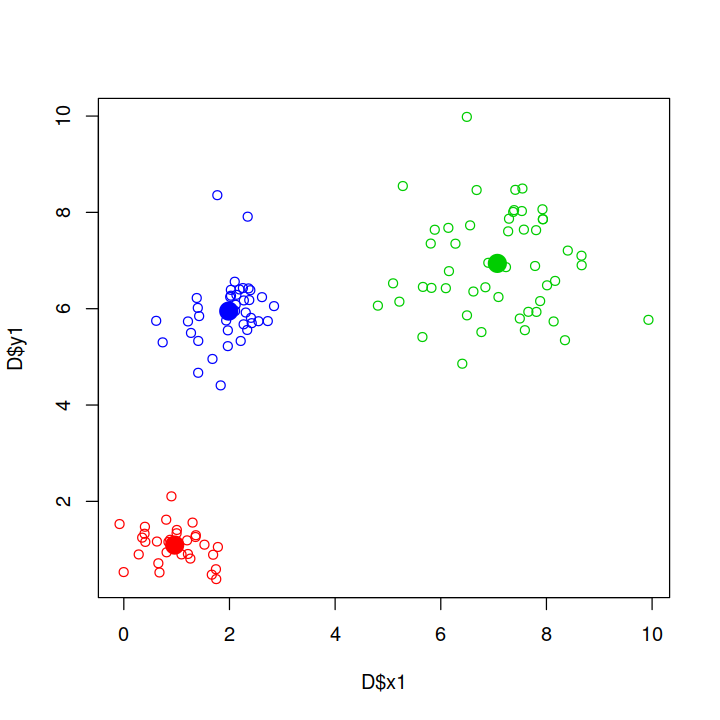

In [15]:
plot(D$x1,D$y1,col=(kmeans.3$cluster+1))

points(kmeans.3$centers,col=seq(1:kmeans.3$ncenters)+1,cex=2,pch=19)

clustering quality as measured by the Calinski-Harabasz index (recommended)

This index measures the dispersion of the data points within the clusters (SSW) and between the clusters (SSB)

A good clustering has small SSW (compact clusters) and large SSB (separated cluster centers)

 There is also a correction for the number of clusters

The CH index is then:

 $CH = (SSB/(K-1)) / (SSW/(N-K))$

 where $N$ is the number of data points and $K$ is the number of clusters

In [16]:
(CH.3 <- clustIndex(kmeans.3,x, index="calinski"))

calinski 
611.0739

now let's not be tricky 

In [17]:
K <- 5 # guess what is going to happen?

execute k-means with a maximum of 100 iterations

In [18]:
kmeans.5 <- cclust (x,K,iter.max=100,method="kmeans",dist="euclidean")

this is your data again, plot initial and final prototypes (centers) and draw arrows to see the process

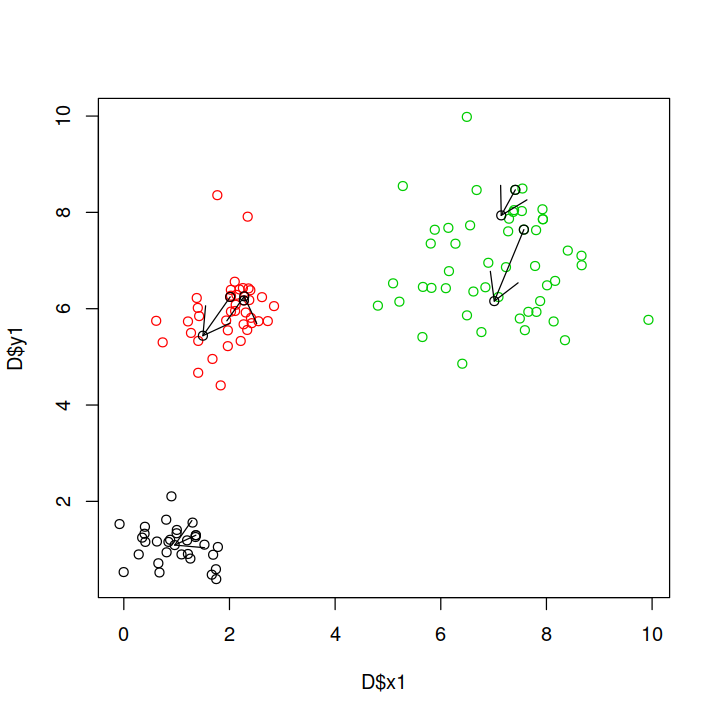

In [19]:
plot(D$x1,D$y1,col=as.vector(D$color))

points(kmeans.5$initcenters)
points(kmeans.5$centers)

arrows (kmeans.5$initcenters[,1], kmeans.5$initcenters[,2],
        kmeans.5$centers[,1], kmeans.5$centers[,2])

plot and paint the clusters (according to the computed assignments), plot the cluster centers

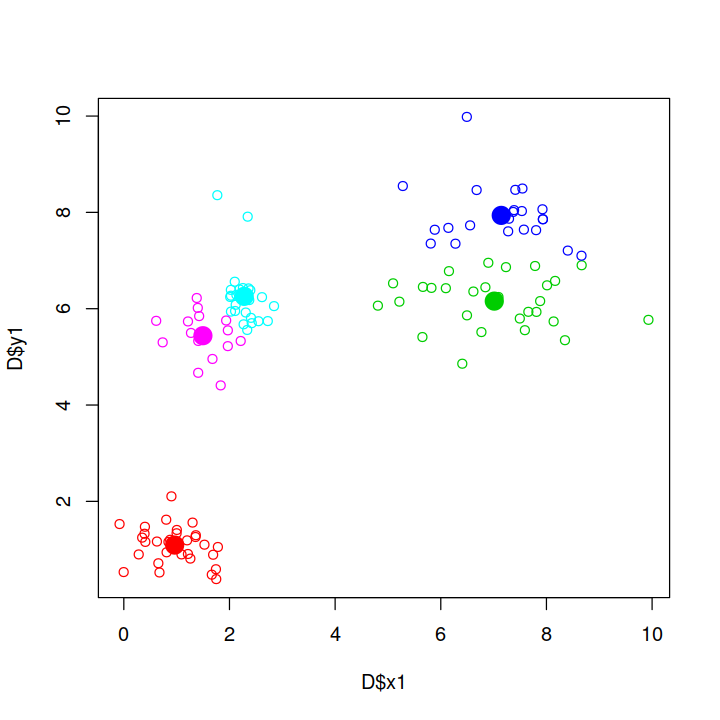

In [20]:
plot(D$x1,D$y1,col=(kmeans.5$cluster+1))

points(kmeans.5$centers,col=seq(1:kmeans.5$ncenters)+1,cex=2,pch=19)

clustering quality as measured by the Calinski-Harabasz index

In [21]:
(CH.5 <- clustIndex(kmeans.5,x, index="calinski"))

calinski 
467.7064

 notice CH.3 > CH.5, so K=3 is better according to C-H

***

## Example 2. Clustering not-so-easy artificial 2D data with k-means and E-M

the MASS library contains the multivariate gaussian

In [22]:
library(MASS)

 the ggplot2 library contains functions for making nice plots

In [23]:
library(ggplot2)
set.seed(333)

 First we need some auxiliary functions



In [24]:
#GENERATE DATA FROM A MIXTURE OF 2D GAUSSIANS
generate.data <- function(N, K, prior.mean, prior.var)
{
  p <- length(prior.mean)
  
  # generate random mixture centres from the prior
  mu_k <- mvrnorm(K, mu=prior.mean, Sigma=diag(prior.var, 2))
  
  # generate mixture coefficients
  pi_k <- runif(K)
  pi_k <- pi_k/sum(pi_k)
  
  # generate the data
  obs <- matrix(0, nrow=N, ncol=p)
  z <- numeric(N)
  sigma_k <- matrix(0, nrow=K, ncol=p)
  
  for (i in 1:K)
    sigma_k[i,] <- runif(p)
  
  for (i in 1:N)
  {
    # draw the observation from a component according to coefficient
    z[i] <- sample(1:K, 1, prob=pi_k)
    # draw the observation from the corresponding mixture location
    obs[i,] <- mvrnorm(1, mu=mu_k[z[i],], Sigma=diag(sigma_k[z[i],],p))
  }
  list(locs=mu_k, z=z, obs=obs, coefs=pi_k)
}

In [25]:
# plot 2d data from a mixture
plot.mixture <- function(locs, z, obs)
{
  stopifnot(dim(obs)[2]==2)
  z <- as.factor(z)
  df1 <- data.frame(x=obs[,1], y=obs[,2], z=z)
  df2 <- data.frame(x=locs[,1], y=locs[,2])
  p <- ggplot()
  p <- p + geom_point(data=df1, aes(x=x, y=y, colour=z), shape=16,
                      size=2, alpha=0.75)
  p <- p + geom_point(data=df2, aes(x=x, y=y), shape=16, size=3)
  p <- p + theme(legend.position="none")
  p
}

In [26]:
# plot 2D data as a scatter plot
plot.data <- function(dat)
{
  stopifnot(dim(dat)[2]==2)
  df1 <- data.frame(x=dat[,1], y=dat[,2])
  p <- ggplot()
  p <- p + geom_point(data=df1, aes(x=x, y=y), size=2, alpha=0.75)
  p
}

Let us generate the data

In [27]:
N <- 1000
K <- 5
centre <- c(0,0)
dispersion <- 10

generate 2D data as a mixture of 5 Gaussians, each axis-aligned (therefore the two variables are independent)
 with different variances
 the centers and coefficients of the mixture are chosen randomly

In [28]:
d <- generate.data (N,K,centre,dispersion)

these are the components of the mixture

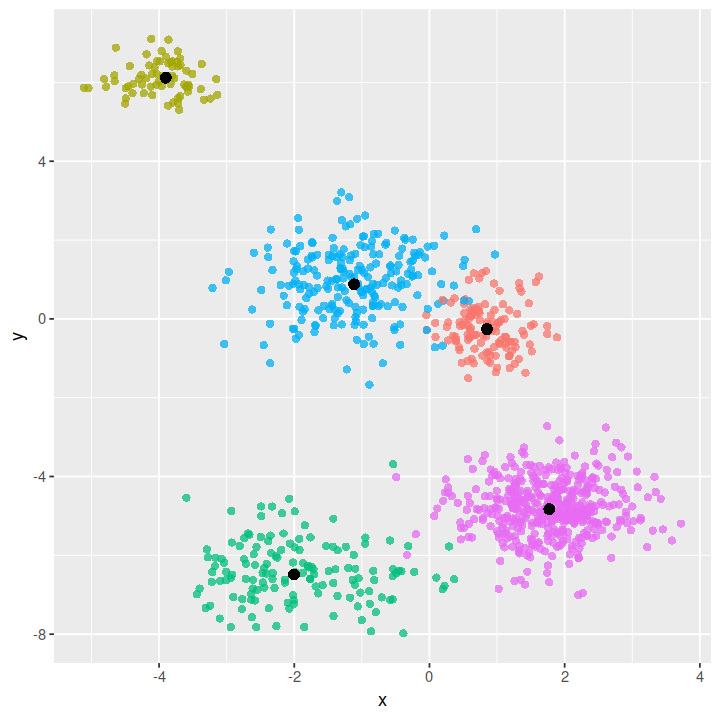

In [29]:
plot.mixture(d$locs, d$z, d$obs)

may be we want to have a look at the unconditional density p(x)

 compute 2D kernel density

In [30]:
z <- kde2d(d$obs[,1], d$obs[,2], n=50)

 some pretty colors

In [31]:

library(RColorBrewer)
colorets <- rev(brewer.pal(11, "RdYlBu"))

 this is the raw data (what the clustering method sees) and   a contour plot of the unconditional density 

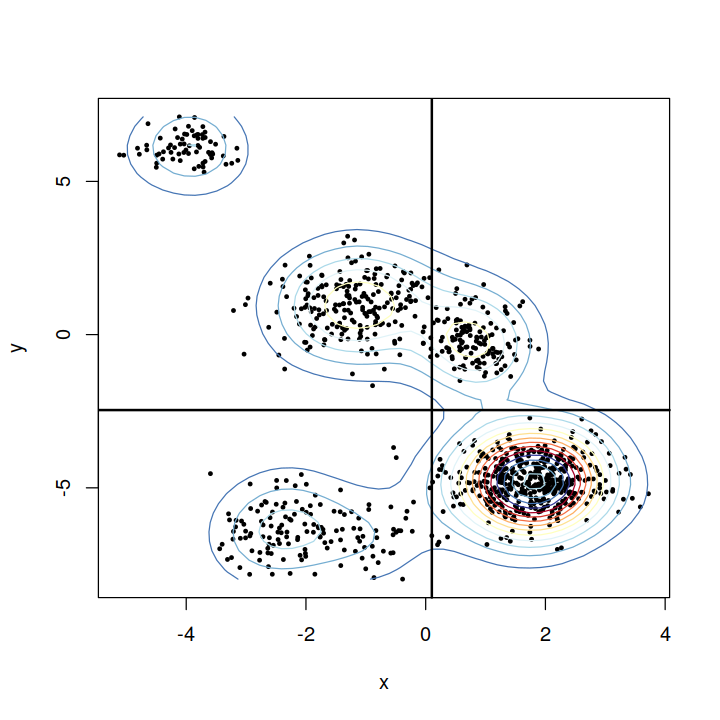

In [32]:
plot(d$obs, xlab="x", ylab="y", pch=19, cex=.4)

contour(z, drawlabels=FALSE, nlevels=22, col=colorets, add=TRUE)
abline(h=mean(d$obs[,2]), v=mean(d$obs[,1]), lwd=2)

a simpler way of plotting the data

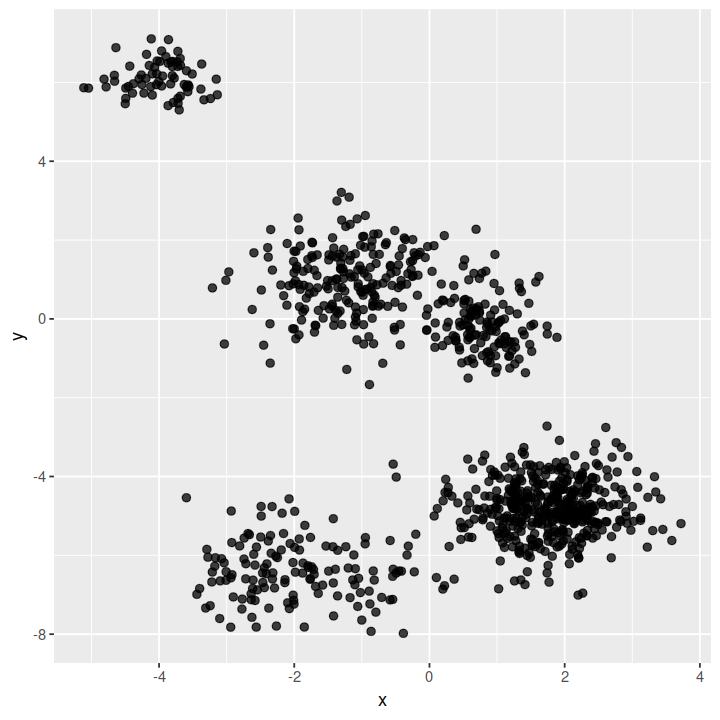

In [33]:
plot.data(d$obs)

let us try first with k-means (K=2)

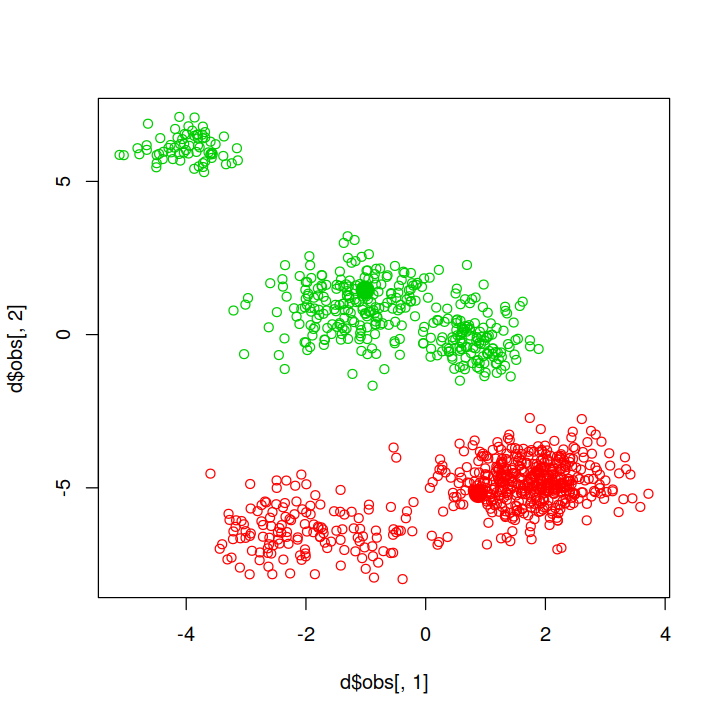

In [34]:
K <- 2

kmeans2.2 <- cclust (d$obs,K,iter.max=100,method="kmeans",dist="euclidean")

plot(d$obs[,1],d$obs[,2],col=(kmeans2.2$cluster+1))
points(kmeans2.2$centers,col=seq(1:kmeans2.2$ncenters)+1,cex=2,pch=19)

 Can we be indulgent with the result? we know the truth is there are 5 clusters,

Is this is a reasonable result if we ask for 2?

clustering quality as measured by the Calinski-Harabasz index

In [35]:
(CH2.2 <- clustIndex(kmeans2.2,d$obs, index="calinski"))

calinski 
2041.235

 let us try now with k-means (K=5)

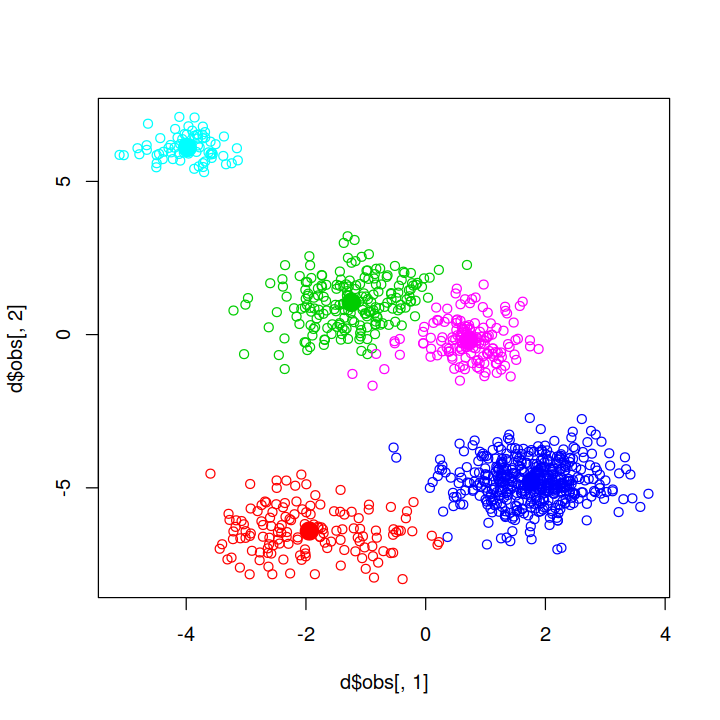

In [36]:
K <- 5

kmeans2.5 <- cclust (d$obs,K,iter.max=100,method="kmeans",dist="euclidean")

plot(d$obs[,1],d$obs[,2],col=(kmeans2.5$cluster+1))
points(kmeans2.5$centers,col=seq(1:kmeans2.5$ncenters)+1,cex=2,pch=19)

 This time the result has even more chances of being largely incorrect
because there are more ways of getting a wrong solution

clustering quality as measured by the Calinski-Harabasz index

In [37]:
(CH2.5 <- clustIndex(kmeans2.5,d$obs, index="calinski"))

calinski 
4251.744

 at least CH2.5 >> CH2.2 ... so C-H does a good job

In class we saw that k-means is usually re-run several times

In [38]:
do.kmeans <- function (whatK)
{
  r <- cclust (d$obs,whatK,iter.max=100,method="kmeans",dist="euclidean")
  (clustIndex(r,d$obs, index="calinski"))
}

max (r <- replicate (100, do.kmeans(5)))

[1] 4251.744

 so it is not a matter of wrong initialization
 this is really the best k-means can do here

 this may take a while

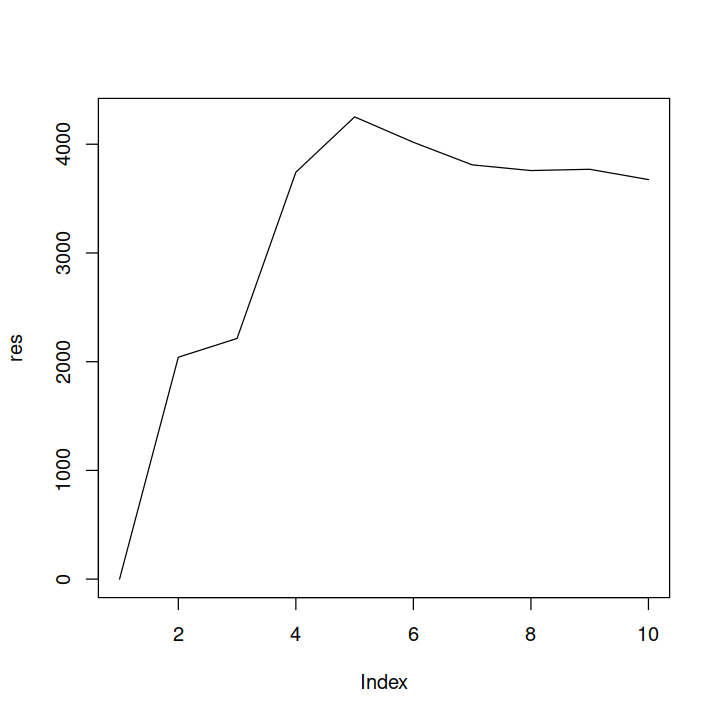

In [39]:
res <- vector("numeric",10)
for (K in 2:10)
  res[K] <- max (r <- replicate (100, do.kmeans(K)))

plot(res, type="l")

 the conclusion is that k-means + C-H bet for 5 clusters ... 
 not bad, not bad ...

 but the real *shape* of the clusters cannot be captured, because k-means only "sees" spherical clusters and these are ellipsoidal

 let us try now E-M

In [40]:
library(Rmixmod)

Loading required package: Rcpp
Rmixmod v. 2.1.2 / URI: www.mixmod.org


This method performs E-M for mixture densities, including mixtures of Gaussians
we can specify which family of gaussians we intend to fit:

* "general" for the general family, "diagonal" for the diagonal family, 

*  "spherical" for the spherical family and "all" for all families (meaning the union)

    WARNING: default is "general".

 suppose first that we know the truth and specify axis-aligned densities (i.e., independent variables)

In [41]:
fammodel <- mixmodGaussianModel (family="diagonal", equal.proportions=FALSE)

z <- mixmodCluster (data.frame(d$obs), models = fammodel, nbCluster = 5)

summary(z)

**************************************************************
* Number of samples    =  1000 
* Problem dimension    =  2 
**************************************************************
*       Number of cluster =  5 
*              Model Type =  Gaussian_pk_Lk_Bk 
*               Criterion =  BIC(7016.0809)
*              Parameters =  list by cluster
*                  Cluster  1 : 
                         Proportion =  0.0680 
                              Means =  -3.9795 6.1025 
                          Variances = |     0.1841     0.0000 |
                                      |     0.0000     0.1673 |
*                  Cluster  2 : 
                         Proportion =  0.2189 
                              Means =  -1.1349 0.9525 
                          Variances = |     0.5681     0.0000 |
                                      |     0.0000     0.7267 |
*                  Cluster  3 : 
                         Proportion =  0.4478 
                              Means = 

 the final centers

In [42]:
(means <- z@bestResult@parameters@mean)

-3.9795341,6.1025470
-1.1348664,0.9525007
1.7672169,-4.7968487
0.8438481,-0.2265113
-1.9238207,-6.4042320


if you want hard assignments

In [43]:
(found.clusters <- z@bestResult@partition)

[1] 2 3 3 5 3 3 3 3 3 2 5 1 3 3 3 2 4 3 3 3 4 3 3 3 2 2 1 2 3 4 1 2 3 3 1 3 3
  [38] 2 4 5 3 2 3 4 2 3 4 5 2 2 3 4 3 4 5 3 2 4 5 3 5 2 3 2 3 3 2 3 2 3 3 4 5 3
  [75] 5 5 4 3 3 3 4 2 3 5 2 3 1 5 5 3 3 3 3 4 4 2 3 4 3 2 3 2 3 3 3 3 4 2 2 5 3
 [112] 3 4 3 3 4 2 3 1 5 2 3 4 3 3 3 2 4 3 3 3 5 4 2 4 3 2 1 3 3 5 4 5 3 3 1 5 3
 [149] 3 3 3 3 3 2 3 3 3 3 5 3 3 3 3 3 3 3 3 2 1 5 3 3 5 1 4 3 5 2 2 3 3 2 5 2 4
 [186] 5 3 5 1 3 2 4 5 3 2 4 2 3 5 2 4 4 1 2 2 1 4 2 3 4 3 3 5 2 2 2 2 3 1 3 4 5
 [223] 2 5 5 3 2 2 4 2 3 3 3 3 3 2 5 3 3 2 3 5 5 3 3 5 3 3 2 1 3 2 2 2 5 3 4 2 5
 [260] 3 1 3 2 5 5 3 3 4 4 3 2 5 3 1 4 3 5 5 2 2 2 2 3 4 2 4 3 4 5 3 3 2 3 3 5 3
 [297] 3 4 5 5 1 3 3 5 2 4 4 2 3 2 3 4 4 5 3 4 1 3 3 3 3 2 2 3 2 3 3 4 3 3 3 3 2
 [334] 1 1 3 2 2 1 3 2 4 2 5 5 3 3 3 5 3 4 3 1 3 3 3 2 3 4 3 2 2 2 3 3 3 3 5 1 2
 [371] 5 4 2 5 5 5 3 5 5 3 2 5 5 3 3 3 2 2 3 3 4 2 2 2 3 5 2 3 5 3 3 4 3 5 3 3 3
 [408] 2 3 3 3 3 3 3 5 2 3 3 5 3 4 3 2 2 4 2 2 5 1 3 4 3 2 2 5 2 3 5 1 1 1 5 3 5
 [445] 3 3 3 1 2 2 3 3 3 2 3 3 3 4 3 3 3 3 2 2 4 2 3 2 5 3 4 3 3 3 4 1 3 3 2 3 3
 [482] 2 5 3 3 4 3 4 3 2 5 4 2 5 3 2 5 3 1 2 3 3 3 3 5 2 3 4 2 3 4 2 3 3 4 2 3 3
 [519] 2 3 1 1 5 5 3 4 3 3 3 5 4 3 2 4 1 2 2 3 2 4 3 3 3 5 4 3 3 3 3 1 3 5 3 1 3
 [556] 5 5 3 3 3 2 1 3 1 5 3 5 3 4 2 3 4 5 2 3 2 2 3 3 1 5 3 2 3 1 3 2 3 2 4 3 2
 [593] 1 3 5 3 3 3 3 3 2 5 1 3 3 3 5 4 5 3 2 2 4 3 3 3 3 2 2 3 4 4 5 3 3 3 1 2 4
 [630] 3 2 3 3 2 2 3 3 2 2 5 3 3 2 2 5 1 3 3 5 3 3 5 2 4 5 4 3 3 3 4 4 3 1 5 3 3
 [667] 3 2 4 3 2 3 2 1 3 3 3 3 3 3 4 3 3 3 4 4 5 2 4 3 3 5 5 2 3 2 3 1 3 5 2 3 3
 [704] 2 3 2 2 4 3 3 3 2 4 3 3 2 2 3 1 3 3 2 3 5 1 4 3 5 5 3 3 2 2 4 3 3 5 2 5 3
 [741] 3 3 2 2 3 3 4 4 2 2 4 3 4 3 2 3 2 5 3 3 2 2 2 5 1 5 1 4 3 4 3 3 4 3 3 3 3
 [778] 3 5 3 3 4 5 5 3 3 1 3 2 5 1 3 4 1 3 2 2 3 4 3 3 1 3 3 3 3 2 4 3 5 2 4 3 3
 [815] 2 3 2 1 5 3 4 5 5 2 2 4 5 4 4 2 4 3 3 3 3 3 5 5 2 2 3 3 5 3 3 3 2 3 3 5 2
 [852] 3 3 5 5 3 5 3 3 4 3 1 4 3 2 4 1 3 3 5 4 1 2 3 5 1 3 3 3 2 3 5 2 1 1 1 4 3
 [889] 4 2 2 2 4 4 3 4 3 3 3 2 1 3 3 3 3 5 2 5 3 3 4 4 3 5 5 3 3 3 3 2 5 3 3 3 3
 [926] 2 5 4 3 3 2 2 1 3 5 5 2 2 2 3 3 3 5 3 3 4 3 2 1 4 3 1 2 3 4 3 2 2 3 4 2 4
 [963] 3 2 3 3 3 4 3 3 3 2 2 3 3 3 3 5 3 2 3 2 4 3 3 2 3 3 3 5 2 3 2 3 2 2 3 1 5
[1000] 3

 other interesting outcomes are:

 the estimated covariance matrices for each cluster

In [44]:
z@bestResult@parameters@variance

0.1840552,0.000000
0.0000000,0.167305
0.5681031,0.0000
0.0000000,0.7267
0.43829,0.0000000
0.00000,0.4818727
0.1572885,0.0000000
0.0000000,0.3783127
0.8493765,0.0000000
0.0000000,0.5555805


 self-explained

In [45]:
z@bestResult@likelihood 

[1] -3425.147

 the posterior probabilities = soft assignments = the gamma_k(x_n) in class

In [46]:
(z@bestResult@proba)

5.378244e-34,9.999994e-01,5.515228e-24,5.938099e-07,2.446627e-28
2.790386e-164,2.333798e-10,9.999998e-01,1.387041e-08,1.817091e-07
1.774785e-198,7.118278e-15,9.999957e-01,5.549683e-15,4.265477e-06
9.474941e-222,2.921002e-18,2.954085e-07,7.659677e-33,9.999997e-01
4.488956e-208,2.363658e-16,1.000000e+00,2.068831e-18,1.791060e-08
2.568679e-203,1.848492e-15,9.999937e-01,6.960039e-16,6.270896e-06
2.049372e-206,6.366546e-16,9.999970e-01,1.521195e-16,3.033571e-06
6.510808e-200,2.539839e-15,1.000000e+00,3.630641e-16,4.101595e-08
4.711541e-222,4.957860e-18,9.999998e-01,1.472532e-20,1.911063e-07
5.122163e-40,1.000000e+00,2.677774e-22,1.109343e-15,3.221830e-20
2.743707e-215,4.222983e-16,2.774001e-03,5.070827e-24,9.972260e-01


 This is a graphical summary of the clustering

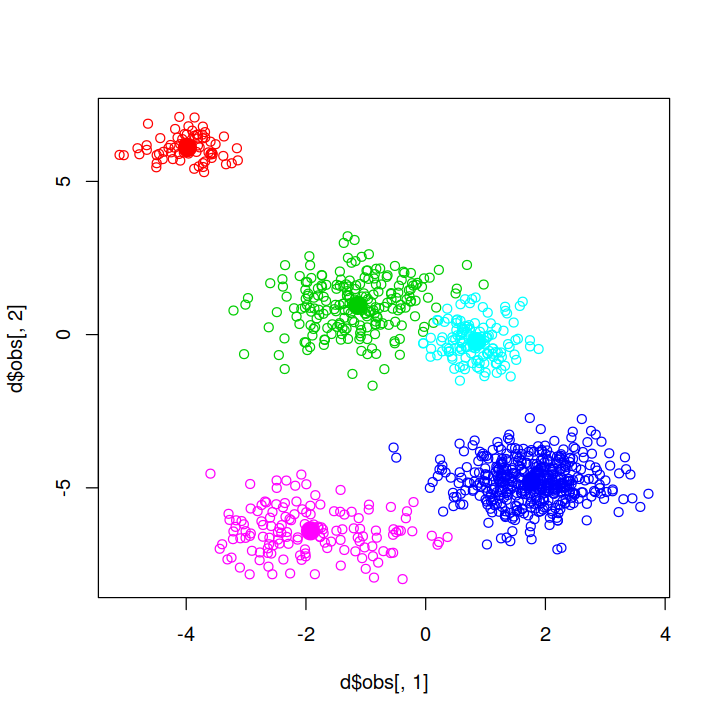

In [47]:
plot(d$obs[,1],d$obs[,2],col=(found.clusters+1))
points(means,col=seq(1:5)+1,cex=2,pch=19)

 it was very likely that E-M performed extremely well
 why? because we knew the truth (cluster form and number)

 suppose now we do not the know the truth but we still wish to fit general gaussians

In [48]:
fammodel <- mixmodGaussianModel (family="general", equal.proportions=FALSE)

z <- mixmodCluster (data.frame(d$obs),models = fammodel, nbCluster = 5)

summary(z)

**************************************************************
* Number of samples    =  1000 
* Problem dimension    =  2 
**************************************************************
*       Number of cluster =  5 
*              Model Type =  Gaussian_pk_Lk_D_Ak_D 
*               Criterion =  BIC(7022.9405)
*              Parameters =  list by cluster
*                  Cluster  1 : 
                         Proportion =  0.2187 
                              Means =  -1.1366 0.9537 
                          Variances = |     0.5638     0.0035 |
                                      |     0.0035     0.7279 |
*                  Cluster  2 : 
                         Proportion =  0.0680 
                              Means =  -3.9795 6.1025 
                          Variances = |     0.1843    -0.0004 |
                                      |    -0.0004     0.1671 |
*                  Cluster  3 : 
                         Proportion =  0.4479 
                              Mean

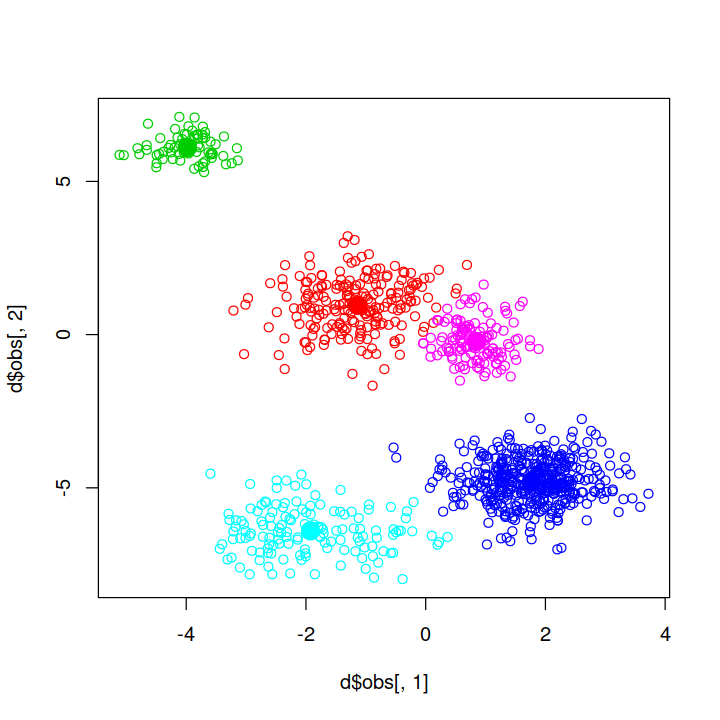

In [49]:
means <- z@bestResult@parameters@mean
found.clusters <- z@bestResult@partition

plot(d$obs[,1],d$obs[,2],col=(found.clusters+1))
points(means,col=seq(1:5)+1,cex=2,pch=19)

 the method works also very smoothly
 why? because the data *is* gaussian

compare the estimated centers

In [50]:
means

-1.1365764,0.9536966
-3.9795341,6.1025470
1.7669497,-4.7968709
-1.9246850,-6.4049024
0.8430279,-0.2263335


 with the truth (note the clusters may appear in a different order)

In [51]:
d$locs

0.8511701,-0.2618734
-3.8992587,6.1179985
-2.0036436,-6.4867479
-1.1153905,0.8782877
1.7724012,-4.8255111


 or the estimated coefficients

In [52]:
sort(z@bestResult@parameters@proportions)

[1] 0.0680000 0.1233403 0.1420896 0.2186604 0.4479097

 with the truth 

In [53]:
sort(d$coefs)

[1] 0.06069612 0.11063047 0.16212800 0.22722402 0.43932139